In [13]:
import numpy as np
import matplotlib.pyplot as plt
import treecorr
import copy
from sklearn.gaussian_process.kernels import RBF
%matplotlib inline

In [14]:
def timer(f):
    import functools

    @functools.wraps(f)
    def f2(*args, **kwargs):
        import time
        import inspect
        t0 = time.time()
        result = f(*args, **kwargs)
        t1 = time.time()
        fname = repr(f).split()[1]
        print('time for %s = %.2f' % (fname, t1-t0))
        return result
    return f2

In [15]:
@timer
def make_2d_grf(kernel, noise=None, seed=42, npoints=40):
    """
    Function to generate a 1D gaussian random field for a 
    given scikit-learn kernel.
    
    :param kernel:  given sklearn kernel.
    :param noise:   float. Level of noise to add to the 
                    gaussian randomn field. (default: None)
    :param seed:    int. seed of the random process. (default: 42) 
    :param npoints: int. number of points to generate for the 
                    simulations.
    """
    # fixing the seed
    np.random.seed(seed)
    # generate random 2D coordinate
    x1 = np.random.uniform(-10,10, npoints)
    x2 = np.random.uniform(-10,10, npoints)
    x = np.array([x1, x2]).T
    # creating the correlation matrix / kernel 
    K = kernel.__call__(x)
    # generating gaussian random field
    y = np.random.multivariate_normal(np.zeros(npoints), K)
    if noise is not None:
        # adding noise
        y += np.random.normal(scale=noise, size=npoints)
        y_err = np.ones_like(y) * noise
        return x, y, y_err
    else:
        return x, y, None


In [16]:
# highly inspired by Gary Bernstein code to compute
# two-point correlation function of E and B mode 
# of vector field. But I guess this is one way
# to compute the two-pcf without writing a loop
# in python (loop are hiden in numpy)
@timer
def comp_pcf_numpy(x, y, kappa, kappa_err=None, binning=None):
    
    # Compute all indexes for pair computation,
    # distance (dr) and pair product (kk)

    ind = np.arange(len(x))

    i1, i2 = np.meshgrid(ind, ind)

    Filtre = (i1 > i2)
    i1 = i1.reshape(len(x)**2)
    i2 = i2.reshape(len(x)**2)
    Filtre = Filtre.reshape(len(x)**2)

    i1 = i1[Filtre]
    i2 = i2[Filtre]
    del Filtre
    
    # Compute distance for all pairs

    dy = y[i2]-y[i1]
    dx = x[i2]-x[i1]
    dr = np.sqrt(dx**2 + dy**2)

    # Compute pair product (weighted if error provided)
    
    if kappa_err is not None:
        weight = 1. / kappa_err**2
        ww = weight[i1] * weight[i2]
    else:
        ww = None

    kk = kappa[i1] * kappa[i2]
    if ww is not None:
        kk *= ww

    # compute 2-pcf

    counts = np.histogram(dr, bins=binning, weights=ww)[0]
    xi, dR = np.histogram(dr, bins=binning, weights=kk)
    xi /= counts

    # take center of the bin, not edge

    dR = copy.deepcopy(dR[:-1]) + (dR[1] - dR[0])/2.

    return xi, dR

In [17]:
class comp_pcf_sid:

    def __init__(self, x, y, kappa_x, kappa_y, binning=None):

        self.x = x
        self.y = y
        self.kappa_x = kappa_x
        self.kappa_y = kappa_y

    def compute_separations(self, xs):
        pts = np.array([xs[0], xs[1]]).T
        seps = np.array([np.sqrt(np.square(pt[0]-pts[:,0])+np.square(pt[1]-pts[:,1])) for pt in pts])
        return seps

    def select_values(self, xs, ys, bins):
        seps = self.compute_separations(xs)
        vals = np.array([ys[0], ys[1]]).T

        return np.vstack([vals[((bins[0] <= sep) & (sep < bins[1]))]
                          if np.sum((bins[0] <= sep) & (sep < bins[1])) > 0
                          else np.array([np.nan, np.nan])
                          for sep in seps])

    def compute_2pcf(self, vals):
        pcfs0 = np.nanmean(np.outer(vals[:,0], vals[:,0])[~np.tri(len(vals),k=-1,dtype=bool)])
        pcfs1 = np.nanmean(np.outer(vals[:,1], vals[:,1])[~np.tri(len(vals),k=-1,dtype=bool)])
        pcfs = np.array([pcfs0, pcfs1])
        return pcfs

    @timer
    def comp_pcf_sid(self):
        # Compute the separations between each point in the field
        seps = compute_separations(np.array())

        # Define distance bins across the range of separation values
        rs = np.histogram_bin_edges(seps, bins=nbins)
        bins = np.array([rs[0:-1], rs[1:]]).T

        # For each bin, select the astrometric-residual values of the points
        # that lie within that distance bin
        vals = [self.select_values(xs, ys, b) for b in bins]

        # Compute the 2-point correlation function for each bin
        pcfs = np.array([self.compute_2pcf(val) for val in vals])

time for make_2d_grf = 0.05


(-10.88421188123008,
 10.795546398167922,
 -10.772126992199864,
 10.983233487528443)

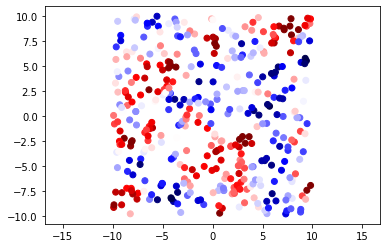

In [18]:
coord, kappa, kappa_err = make_2d_grf(RBF(1), seed=42, npoints=400)
plt.scatter(coord[:,0], coord[:,1], c=kappa, vmin=-2, vmax=2, cmap=plt.cm.seismic)
plt.axis('equal')